In [53]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [54]:
df = pd.read_csv('C:/Users/JW/Desktop/khl/data/train_set.csv')
df1 = pd.read_csv('C:/Users/JW/Desktop/khl/data/test_set.csv')


In [55]:
scaler = MinMaxScaler()
scaled_col = [col for col in df.columns]
df[scaled_col] = scaler.fit_transform(df[scaled_col])


In [56]:
df.head()

,air_temp,TSI,azimuth,altitude,solar_rad,High_solar_rad,casi,humidity,rain,wind_speed,wind_direction,rail_direction,rail_temp
0,0.500,0.0,0.970885,0.125443,0.0,0.0,0.0,0.611940,0.0,0.674095,0.119760,0.0,0.310421
1,0.496,0.0,0.978510,0.122791,0.0,0.0,0.0,0.611940,0.0,0.548747,0.091816,0.0,0.305987
2,0.492,0.0,0.986197,0.120924,0.0,0.0,0.0,0.611940,0.0,0.565460,0.035928,0.0,0.303769
3,0.488,0.0,0.993924,0.119852,0.0,0.0,0.0,0.611940,0.0,0.704735,0.097804,0.0,0.299335
4,0.480,0.0,0.000187,0.119580,0.0,0.0,0.0,0.626866,0.0,0.529248,0.083832,0.0,0.294900


In [57]:
X = df.iloc[:,:12].values
y = df.iloc[:,12].values

In [58]:
X.shape

(7000, 12)

In [59]:
def sequence_data(X,y, sequence_size):
    x_seq = []
    y_seq = []
    for idx in range(len(X) - sequence_size):
        x_seq.append(X[idx:idx + sequence_size])
        y_seq.append(y[idx + sequence_size])
        
    return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32).view(-1,1)

In [60]:
split = 200
sequence_length = 5
X_seq, y_seq = sequence_data(X, y, sequence_length)

X_train_seq = X_seq[:split]
y_train_seq = y_seq[:split]
X_test_seq = X_seq[split:]
y_test_seq = y_seq[split:]

In [61]:
from torch.utils.data import TensorDataset

In [62]:
train_set = TensorDataset(X_train_seq, y_train_seq)
test_set = TensorDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_set, batch_size = 16)
test_loader = DataLoader(test_set, batch_size = 16)

In [63]:
input_size = X_seq.size(2)
num_layers = 2
hidden_size = 12

In [64]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.sequence_length = sequence_length
        self.device = device
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True).to(self.device)
        self.fc = nn.Sequential(
            nn.Linear(self.hidden_size * self.sequence_length, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNN(input_size, hidden_size, 5, num_layers, device).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=1e-3)

loss_graph = []
n = len(train_loader)

for epoch in range(50):
    running_loss = 0
    for data in train_loader:
        seq, target = data[0].to(device), data[1].to(device)
        
        out = model(seq)
        loss = criterion(out, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print("[epoch: %d] loss : %.4f" %(epoch,running_loss/n))

[epoch: 0] loss : 0.0594
[epoch: 10] loss : 0.0027
[epoch: 20] loss : 0.0020
[epoch: 30] loss : 0.0016
[epoch: 40] loss : 0.0014


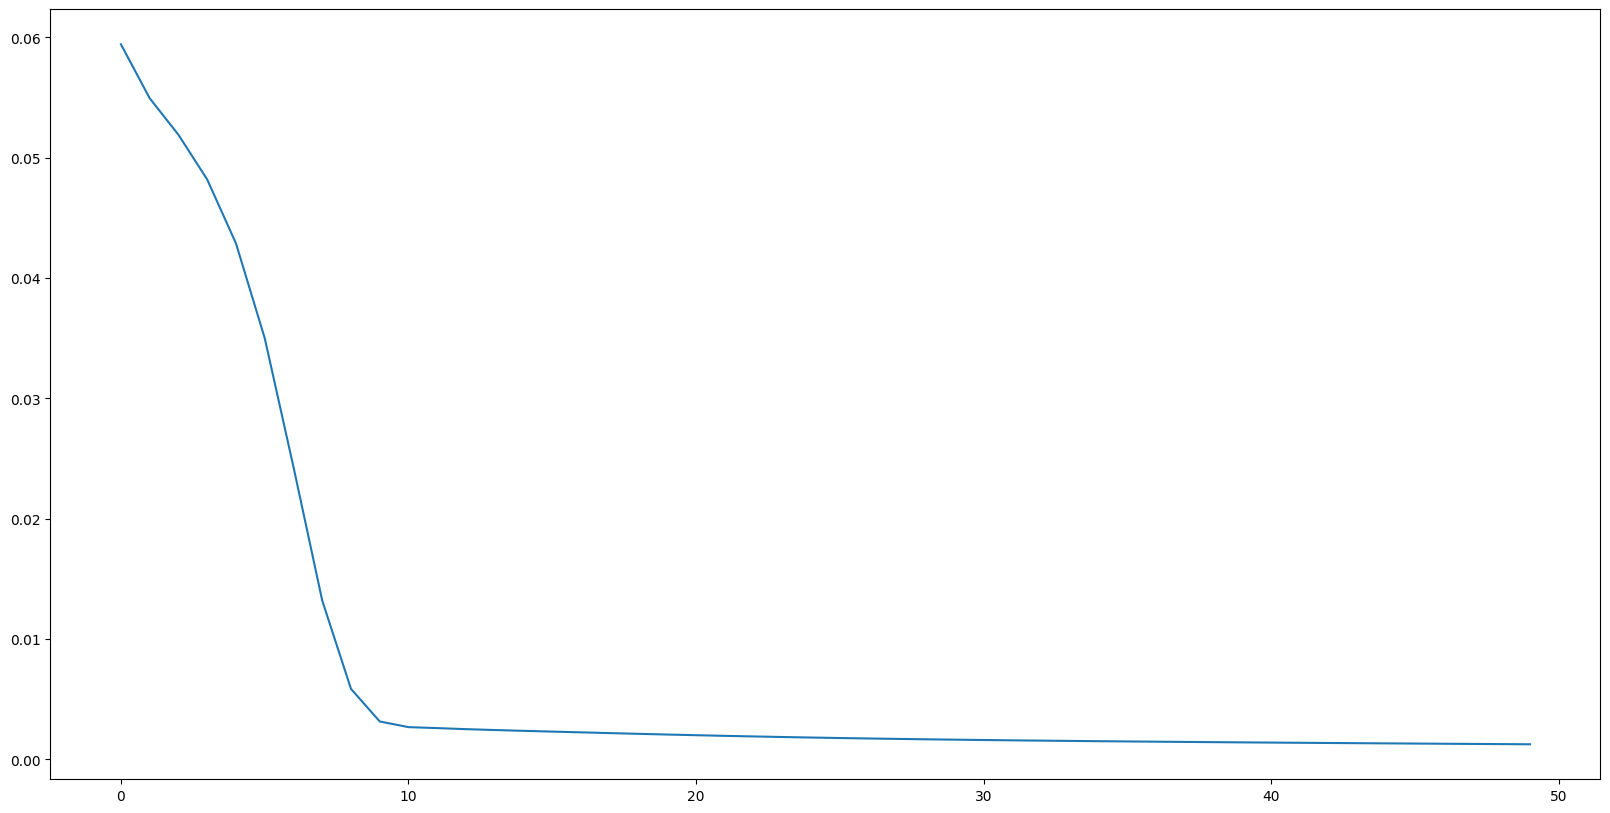

In [66]:
plt.figure(figsize=(20, 10))
plt.plot(loss_graph)
plt.show()

In [67]:
concatdata = torch.utils.data.ConcatDataset([train_set, test_set])
data_loader = DataLoader(dataset=concatdata, batch_size= 16)

model.eval()
with torch.no_grad():
    pred = []
    for data in data_loader:
        seq, target = data[0].to(device), data[1].to(device)
        out = model(seq)
        pred += out.cpu().tolist()


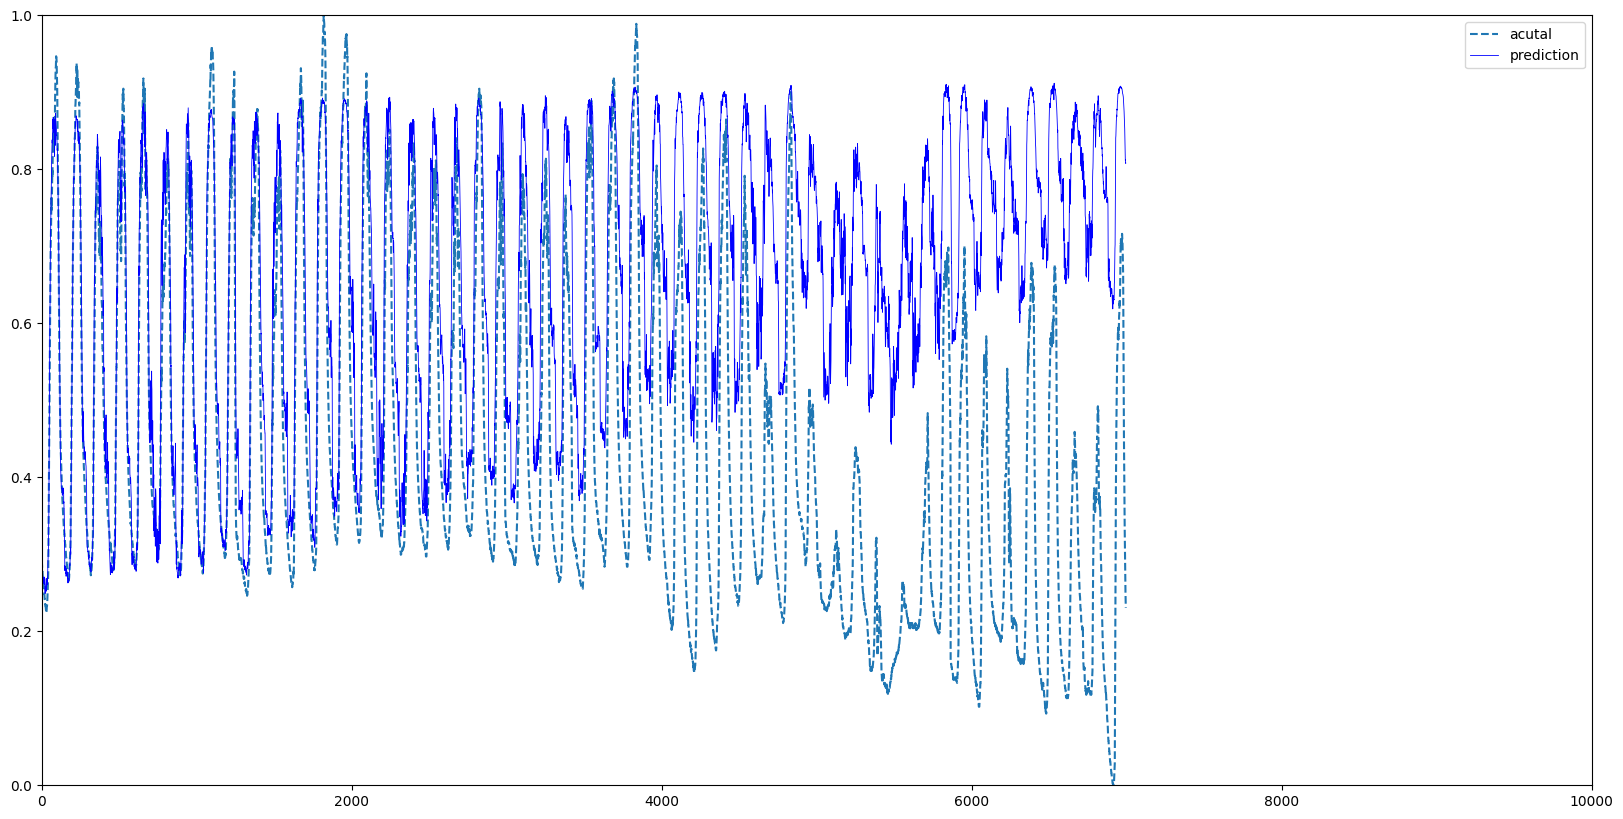

In [72]:
plt.figure(figsize=(20,10))
plt.plot(df['rail_temp'][sequence_length:].values,'--')
plt.xlim(0, 10000)
plt.ylim(0, 1)
plt.plot(pred, 'b', linewidth=0.6)
plt.legend(['acutal', 'prediction'])

plt.show()